# Transfer Learning: Shallow Learning vs Finetuning

This notebook explores transfer learning for image classification using a pre-trained ResNet50 model. It involves fine-tuning the model and using it as a fixed feature extractor.

## Overview
The key steps involve selecting a target dataset, fine-tuning the pre-trained model, and using the model as a feature extractor.

## Procedure
- **Dataset Selection**: Select a target dataset from the Visual-Decathlon challenge, describe its features, and show sample images.
- **Fine-tuning**:
  - Load pre-trained ResNet50, change the final layer, and fine-tune with a learning rate of 0.001, momentum of 0.9, batch size of 64, and a multi-step learning rate schedule.
  - Experiment with learning rates of 0.01 and 0.1, and compare accuracy.
- **Feature Extractor**:
  - Train only the final layer with learning rates of 1, 0.1, 0.01, and 0.001, keeping other hyperparameters the same.
  - Compare the best final accuracy from both transfer learning approaches.

References:
- [Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [CS231n Transfer Learning](https://cs231n.github.io/transfer-learning/)
- [Visual Domain Decathlon](https://www.robots.ox.ac.uk/vgg/decathlon/)

In [15]:
import torchvision.models as models

In [16]:

# Load the pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# If you want to see the model architecture, you can print it
print(resnet50)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

| Dataset  | Ebase | No. of Classes | Training | Validation | Testing |
|----------|-------|----------------|----------|------------|---------|
| Aircraft | 39.66 | 100            | 3333     | 3333       | 3333    |

In [17]:
import torch.nn as nn
import torch.optim as optim
import torch
device = torch.device("mps")
torch.set_default_dtype(torch.float32)


In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset

from PIL import Image
import glob

class TestDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        # List all images in the directory
        self.image_paths = glob.glob(directory + '/*.jpg')  # Adjust the pattern if needed

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = Subset(datasets.ImageFolder('./data/decathlon-1.0-data/aircraft/train', transform=transform), range(1000))
val_dataset = datasets.ImageFolder('./data/decathlon-1.0-data/aircraft/val', transform=transform)
test_dataset = TestDataset('./data/decathlon-1.0-data/aircraft/test', transform=transform)

# Data loaders
loader_gpu_config = {'num_workers': 6, 'pin_memory': True, 'persistent_workers': True}

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **loader_gpu_config)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **loader_gpu_config)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **loader_gpu_config)


In [11]:
enumerate(train_loader)
enumerate(val_loader)


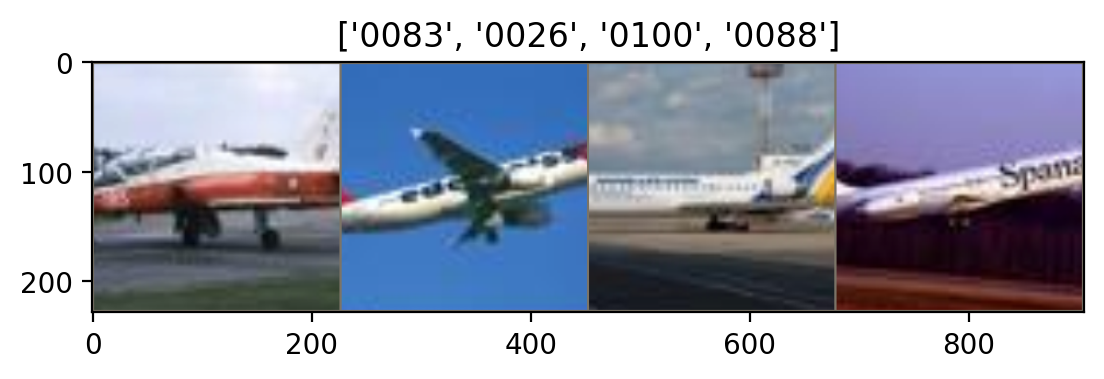

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[train_dataset.classes[x] for x in classes[:4]])


In [19]:
import torch.optim as optim
import torch
device = torch.device("mps")
torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.float32)


In [12]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=60, patience=5):
    best_loss = float('inf')
    best_accuracy = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Progress bar
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        losses, accuracies = [], []
        for i, (inputs, labels) in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            acc = torch.sum(preds == labels.data)
            running_corrects += acc

            losses.append(loss.item())
            accuracies.append(acc)

            progress_bar.set_description(f"Epoch {epoch+1} / {num_epochs}")
            progress_bar.set_postfix(loss=running_loss/((i+1)*train_loader.batch_size), acc=float(running_corrects)/((i+1)*train_loader.batch_size))

        scheduler.step()  # Update learning rate

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects / len(train_dataset)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_running_corrects = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = val_running_corrects / len(val_dataset)
        print(f"Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}")

        # Check for early stopping
        # if val_epoch_loss < best_loss:
        if val_epoch_acc > best_accuracy:
            best_loss = val_epoch_loss
            best_accuracy = val_epoch_acc
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f'best loss: {best_loss:.4f}, best acc: {best_accuracy:.4f}')
    return model, losses, accuracies


resnet50 = models.resnet50(pretrained=True)

num_ftrs = resnet50.fc.in_features
num_classes = len(train_dataset.dataset.classes)
resnet50.fc = nn.Linear(num_ftrs, num_classes)

resnet50 = resnet50.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)

# Train the model
trained_model, losses, accuracies = train_model(resnet50, criterion, optimizer, scheduler, num_epochs=60)


/Users/darien/miniforge3/envs/MetalTF/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/darien/miniforge3/envs/MetalTF/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 / 60: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, acc=0.0225, loss=4.32]


Val Loss: 4.7830 Val Acc: 0.0129


Epoch 2 / 60: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s, acc=0.0654, loss=3.63]


Val Loss: 5.2840 Val Acc: 0.0180


Epoch 3 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, acc=0.146, loss=3.32]


Val Loss: 5.6930 Val Acc: 0.0225


Epoch 4 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s, acc=0.262, loss=3.14]


Val Loss: 5.9097 Val Acc: 0.0282


Epoch 5 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, acc=0.37, loss=3]    


Val Loss: 6.0994 Val Acc: 0.0240


Epoch 6 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s, acc=0.415, loss=2.84]


Val Loss: 6.2115 Val Acc: 0.0288


Epoch 7 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, acc=0.587, loss=2.68]


Val Loss: 6.3099 Val Acc: 0.0324


Epoch 8 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s, acc=0.688, loss=2.5] 


Val Loss: 6.3974 Val Acc: 0.0375


Epoch 9 / 60: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, acc=0.736, loss=2.32]


Val Loss: 6.4809 Val Acc: 0.0315


Epoch 10 / 60: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, acc=0.821, loss=2.11]


Val Loss: 6.5139 Val Acc: 0.0366


Epoch 11 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, acc=0.879, loss=1.87]


Val Loss: 6.5640 Val Acc: 0.0378


Epoch 12 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s, acc=0.892, loss=1.65]


Val Loss: 6.6421 Val Acc: 0.0378


Epoch 13 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, acc=0.929, loss=1.41]


Val Loss: 6.7382 Val Acc: 0.0345


Epoch 14 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s, acc=0.954, loss=1.17]


Val Loss: 6.7832 Val Acc: 0.0423


Epoch 15 / 60: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, acc=0.968, loss=0.942]


Val Loss: 6.7880 Val Acc: 0.0381


Epoch 16 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, acc=0.973, loss=0.775]


Val Loss: 6.7771 Val Acc: 0.0408


Epoch 17 / 60: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, acc=0.974, loss=0.758]


Val Loss: 6.7817 Val Acc: 0.0396


Epoch 18 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, acc=0.973, loss=0.74] 


Val Loss: 6.7951 Val Acc: 0.0405


Epoch 19 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, acc=0.975, loss=0.72] 


Val Loss: 6.7969 Val Acc: 0.0405
Early stopping at epoch 19
best loss: 6.7832


#### 2.c


In [13]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models

def train_model_with_lr(learning_rate):
    print(f"Training with learning rate: {learning_rate}")

    resnet50 = models.resnet50(pretrained=True)
    num_ftrs = resnet50.fc.in_features
    resnet50.fc = nn.Linear(num_ftrs, len(train_dataset.dataset.classes))
    resnet50 = resnet50.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(resnet50.parameters(), lr=learning_rate, momentum=0.9)

    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)

    trained_model, losses, accuracies = train_model(resnet50, criterion, optimizer, scheduler, num_epochs=60)
    return trained_model, losses, accuracies

print('\ntraining with lr of 0.01')
trained_model_001, losses_001, accuracies_001 = train_model_with_lr(0.01)

print('\n\ntraining with lr of 0.1')
trained_model_01, losses_01, accuracies_01 = train_model_with_lr(0.1)





training with lr of 0.01
Training with learning rate: 0.01


/Users/darien/miniforge3/envs/MetalTF/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/darien/miniforge3/envs/MetalTF/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 / 60: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s, acc=0.0342, loss=3.73]


Val Loss: 7.8481 Val Acc: 0.0135


Epoch 2 / 60: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, acc=0.15, loss=3.06] 


Val Loss: 10.0016 Val Acc: 0.0282


Epoch 3 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s, acc=0.431, loss=2.12]


Val Loss: 9.1456 Val Acc: 0.0432


Epoch 4 / 60: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, acc=0.779, loss=1.02]


Val Loss: 9.4286 Val Acc: 0.0552


Epoch 5 / 60: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s, acc=0.925, loss=0.366]


Val Loss: 9.4245 Val Acc: 0.0567


Epoch 6 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s, acc=0.973, loss=0.0843]


Val Loss: 9.2902 Val Acc: 0.0591


Epoch 7 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, acc=0.976, loss=0.0242]


Val Loss: 9.3299 Val Acc: 0.0732


Epoch 8 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s, acc=0.977, loss=0.00937]


Val Loss: 9.3144 Val Acc: 0.0762


Epoch 9 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s, acc=0.977, loss=0.00597]


Val Loss: 9.3340 Val Acc: 0.0762


Epoch 10 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, acc=0.977, loss=0.00434]


Val Loss: 9.3483 Val Acc: 0.0750


Epoch 11 / 60: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, acc=0.977, loss=0.00341]


Val Loss: 9.3635 Val Acc: 0.0753


Epoch 12 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, acc=0.977, loss=0.00298]


Val Loss: 9.3617 Val Acc: 0.0756


Epoch 13 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s, acc=0.977, loss=0.00253]


Val Loss: 9.3872 Val Acc: 0.0777


Epoch 14 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s, acc=0.977, loss=0.00239]


Val Loss: 9.3681 Val Acc: 0.0762


Epoch 15 / 60: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, acc=0.977, loss=0.00263]


Val Loss: 9.3935 Val Acc: 0.0771


Epoch 16 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, acc=0.977, loss=0.00218]


Val Loss: 9.3852 Val Acc: 0.0762


Epoch 17 / 60: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s, acc=0.977, loss=0.00235]


Val Loss: 9.3754 Val Acc: 0.0756


Epoch 18 / 60: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s, acc=0.977, loss=0.00214]


Val Loss: 9.3813 Val Acc: 0.0762
Early stopping at epoch 18
best loss: 9.3872


training with lr of 0.1
Training with learning rate: 0.1


Epoch 1 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, acc=0.0312, loss=4.92]


Val Loss: 16381540.4056 Val Acc: 0.0099


Epoch 2 / 60: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, acc=0.0283, loss=4.3] 


Val Loss: 5835.5915 Val Acc: 0.0099


Epoch 3 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, acc=0.0371, loss=3.68]


Val Loss: 8.6865 Val Acc: 0.0114


Epoch 4 / 60: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, acc=0.0303, loss=3.44]


Val Loss: 6.9508 Val Acc: 0.0072


Epoch 5 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, acc=0.0332, loss=3.38]


Val Loss: 7.4349 Val Acc: 0.0117


Epoch 6 / 60: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, acc=0.0381, loss=3.36]


Val Loss: 7.1226 Val Acc: 0.0114


Epoch 7 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s, acc=0.0342, loss=3.36]


Val Loss: 7.2212 Val Acc: 0.0129


Epoch 8 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, acc=0.0322, loss=3.35]


Val Loss: 7.1273 Val Acc: 0.0141


Epoch 9 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.20it/s, acc=0.0352, loss=3.34]


Val Loss: 7.2454 Val Acc: 0.0120


Epoch 10 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s, acc=0.0303, loss=3.35]


Val Loss: 7.2455 Val Acc: 0.0126


Epoch 11 / 60: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s, acc=0.0371, loss=3.34]


Val Loss: 7.2966 Val Acc: 0.0096


Epoch 12 / 60: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, acc=0.0361, loss=3.32]


Val Loss: 7.3754 Val Acc: 0.0132


Epoch 13 / 60: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, acc=0.0371, loss=3.32]


Val Loss: 7.5433 Val Acc: 0.0120
Early stopping at epoch 13
best loss: 7.1273


### Part 2.a


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract=True):
    model = models.resnet50(pretrained=True)
    set_parameter_requires_grad(model, feature_extract)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def train_model_feature_extract(learning_rate):
    print(f"Training only the last layer with learning rate: {learning_rate}")

    model = initialize_model(len(train_dataset.dataset.classes))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=0.9)

    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)

    trained_model, losses, accuracies = train_model(model, criterion, optimizer, scheduler, num_epochs=60)
    return trained_model, losses, accuracies

learning_rates = [1, 0.1, 0.01, 0.001]

for lr in learning_rates:
    trained_model, losses, accuracies = train_model_feature_extract(lr)


Training only the last layer with learning rate: 1


Epoch 1 / 60: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s, acc=0.0332, loss=316] 


Val Loss: 999.6215 Val Acc: 0.0135


Epoch 2 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s, acc=0.0498, loss=1.11e+3]


Val Loss: 1149.5748 Val Acc: 0.0099


Epoch 3 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s, acc=0.0449, loss=828]   


Val Loss: 1076.4170 Val Acc: 0.0123


Epoch 4 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s, acc=0.0801, loss=625]


Val Loss: 500.4777 Val Acc: 0.0219


Epoch 5 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s, acc=0.144, loss=289]


Val Loss: 406.6633 Val Acc: 0.0291


Epoch 6 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s, acc=0.244, loss=137]


Val Loss: 294.9020 Val Acc: 0.0252


Epoch 7 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s, acc=0.393, loss=69.8]


Val Loss: 254.6497 Val Acc: 0.0228


Epoch 8 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s, acc=0.479, loss=33.6]


Val Loss: 254.5974 Val Acc: 0.0246


Epoch 9 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s, acc=0.522, loss=34]  


Val Loss: 241.0908 Val Acc: 0.0261


Epoch 10 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s, acc=0.546, loss=23.8]


Val Loss: 240.5223 Val Acc: 0.0288
Early stopping at epoch 10
best loss: 406.6633
Training only the last layer with learning rate: 0.1


Epoch 1 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s, acc=0.042, loss=8.83] 


Val Loss: 35.2682 Val Acc: 0.0150


Epoch 2 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s, acc=0.0703, loss=32.2]


Val Loss: 49.9227 Val Acc: 0.0165


Epoch 3 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s, acc=0.0947, loss=36.1]


Val Loss: 56.9674 Val Acc: 0.0174


Epoch 4 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s, acc=0.125, loss=32.8]


Val Loss: 50.6605 Val Acc: 0.0225


Epoch 5 / 60: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s, acc=0.188, loss=24]  


Val Loss: 43.3854 Val Acc: 0.0240


Epoch 6 / 60: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s, acc=0.285, loss=15.5]


Val Loss: 29.3042 Val Acc: 0.0225


Epoch 7 / 60: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s, acc=0.407, loss=4.71]


Val Loss: 27.5537 Val Acc: 0.0249


Epoch 8 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s, acc=0.522, loss=2.73]


Val Loss: 25.5541 Val Acc: 0.0255


Epoch 9 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s, acc=0.593, loss=2.02]


Val Loss: 26.4584 Val Acc: 0.0276


Epoch 10 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s, acc=0.682, loss=1.17]


Val Loss: 25.7400 Val Acc: 0.0231


Epoch 11 / 60: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s, acc=0.713, loss=0.971]


Val Loss: 25.6481 Val Acc: 0.0273


Epoch 12 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s, acc=0.702, loss=1.1] 


Val Loss: 26.5497 Val Acc: 0.0291


Epoch 13 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s, acc=0.72, loss=1.07] 


Val Loss: 24.9011 Val Acc: 0.0306


Epoch 14 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s, acc=0.842, loss=0.476]


Val Loss: 24.8762 Val Acc: 0.0279


Epoch 15 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s, acc=0.799, loss=0.593]


Val Loss: 24.8187 Val Acc: 0.0270


Epoch 16 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s, acc=0.914, loss=0.198]


Val Loss: 24.3210 Val Acc: 0.0321


Epoch 17 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s, acc=0.945, loss=0.109]


Val Loss: 24.3422 Val Acc: 0.0309


Epoch 18 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s, acc=0.953, loss=0.108] 


Val Loss: 24.3221 Val Acc: 0.0312


Epoch 19 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.78it/s, acc=0.959, loss=0.0855]


Val Loss: 24.2299 Val Acc: 0.0306


Epoch 20 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.81it/s, acc=0.961, loss=0.0793]


Val Loss: 24.3167 Val Acc: 0.0318


Epoch 21 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s, acc=0.957, loss=0.0877]


Val Loss: 24.2142 Val Acc: 0.0327


Epoch 22 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s, acc=0.964, loss=0.081] 


Val Loss: 24.2434 Val Acc: 0.0315


Epoch 23 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s, acc=0.964, loss=0.0769]


Val Loss: 24.2756 Val Acc: 0.0306


Epoch 24 / 60: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s, acc=0.964, loss=0.0712]


Val Loss: 24.2127 Val Acc: 0.0318


Epoch 25 / 60: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, acc=0.949, loss=0.0949]


Val Loss: 24.3081 Val Acc: 0.0321


Epoch 26 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.78it/s, acc=0.967, loss=0.0669]


Val Loss: 24.3528 Val Acc: 0.0318
Early stopping at epoch 26
best loss: 24.2142
Training only the last layer with learning rate: 0.01


Epoch 1 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s, acc=0.0244, loss=3.77]


Val Loss: 7.3581 Val Acc: 0.0186


Epoch 2 / 60: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s, acc=0.0879, loss=3.22]


Val Loss: 8.7168 Val Acc: 0.0216


Epoch 3 / 60: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s, acc=0.152, loss=3.02]


Val Loss: 9.2866 Val Acc: 0.0237


Epoch 4 / 60: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, acc=0.229, loss=2.77]


Val Loss: 9.2310 Val Acc: 0.0306


Epoch 5 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.76it/s, acc=0.26, loss=2.59] 


Val Loss: 9.3145 Val Acc: 0.0264


Epoch 6 / 60: 100%|██████████| 16/16 [00:05<00:00,  2.88it/s, acc=0.325, loss=2.46]


Val Loss: 9.3854 Val Acc: 0.0252


Epoch 7 / 60: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s, acc=0.363, loss=2.28]


Val Loss: 9.4272 Val Acc: 0.0306


Epoch 8 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s, acc=0.421, loss=2.17]


Val Loss: 9.5064 Val Acc: 0.0321


Epoch 9 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s, acc=0.467, loss=2.05]


Val Loss: 9.5910 Val Acc: 0.0312


Epoch 10 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s, acc=0.48, loss=1.98] 


Val Loss: 9.5832 Val Acc: 0.0315


Epoch 11 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s, acc=0.516, loss=1.87]


Val Loss: 9.6757 Val Acc: 0.0318


Epoch 12 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s, acc=0.55, loss=1.76] 


Val Loss: 9.6628 Val Acc: 0.0300


Epoch 13 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s, acc=0.571, loss=1.7] 


Val Loss: 9.7332 Val Acc: 0.0300
Early stopping at epoch 13
best loss: 9.5064
Training only the last layer with learning rate: 0.001


Epoch 1 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s, acc=0.0283, loss=4.29]


Val Loss: 4.7789 Val Acc: 0.0084


Epoch 2 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s, acc=0.0303, loss=3.69]


Val Loss: 5.2786 Val Acc: 0.0120


Epoch 3 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s, acc=0.0693, loss=3.44]


Val Loss: 5.6828 Val Acc: 0.0144


Epoch 4 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s, acc=0.0859, loss=3.35]


Val Loss: 5.9288 Val Acc: 0.0162


Epoch 5 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s, acc=0.0986, loss=3.29]


Val Loss: 6.0888 Val Acc: 0.0162


Epoch 6 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s, acc=0.135, loss=3.24]


Val Loss: 6.2147 Val Acc: 0.0198


Epoch 7 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s, acc=0.158, loss=3.2] 


Val Loss: 6.3062 Val Acc: 0.0240


Epoch 8 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s, acc=0.167, loss=3.17]


Val Loss: 6.4060 Val Acc: 0.0228


Epoch 9 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s, acc=0.206, loss=3.13]


Val Loss: 6.4722 Val Acc: 0.0258


Epoch 10 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s, acc=0.206, loss=3.1] 


Val Loss: 6.5396 Val Acc: 0.0225


Epoch 11 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s, acc=0.233, loss=3.06]


Val Loss: 6.6052 Val Acc: 0.0255


Epoch 12 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s, acc=0.221, loss=3.03]


Val Loss: 6.6703 Val Acc: 0.0237


Epoch 13 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s, acc=0.268, loss=3]   


Val Loss: 6.7275 Val Acc: 0.0288


Epoch 14 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s, acc=0.3, loss=2.97]  


Val Loss: 6.7785 Val Acc: 0.0276


Epoch 15 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s, acc=0.309, loss=2.94]


Val Loss: 6.8209 Val Acc: 0.0303


Epoch 16 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s, acc=0.336, loss=2.91]


Val Loss: 6.8337 Val Acc: 0.0294


Epoch 17 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s, acc=0.34, loss=2.91] 


Val Loss: 6.8404 Val Acc: 0.0294


Epoch 18 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s, acc=0.326, loss=2.91]


Val Loss: 6.8182 Val Acc: 0.0297


Epoch 19 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s, acc=0.337, loss=2.9] 


Val Loss: 6.8196 Val Acc: 0.0297


Epoch 20 / 60: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s, acc=0.347, loss=2.9] 


Val Loss: 6.8458 Val Acc: 0.0294
Early stopping at epoch 20
best loss: 6.8209


Best accuracies for each learning rate:

* 1 - 0.0288
* 0.1 - 0.0327
* 0.01 - 0.0321
* 0.001 - 0.0303

Best Accuracy with learning rate 0.1: 0.0327


### part b


The highest accuracy was achieved with the method used in part b. The second best model was the one with the feature extractor approach in part a. Fine-tuning essentially allows the model to learn the weights of the entire model, while the feature extractor approach only allows the model to learn the weights of the last layer. This is why the fine-tuning approach is better.